In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [5]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 53.861 s
  auxilliary:  26.301 s
          sf:   8.881 s
interpolator:  18.679 s


## Along scan error

In [6]:
# Individual measurement error
sigma_al = np.array(pd.read_csv('astromet/data/scatteral_edr3.csv', usecols=['magbin','var_al_50']))
sigma_al_interp = scipy.interpolate.interp1d(sigma_al[:,0], sigma_al[:,1], bounds_error=False)

# Single source

In [11]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))
params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

# Get rid of binary signal for the moment
params.a = 0.

In [12]:
rac_track, dec_track=astromet.track(ts,params)

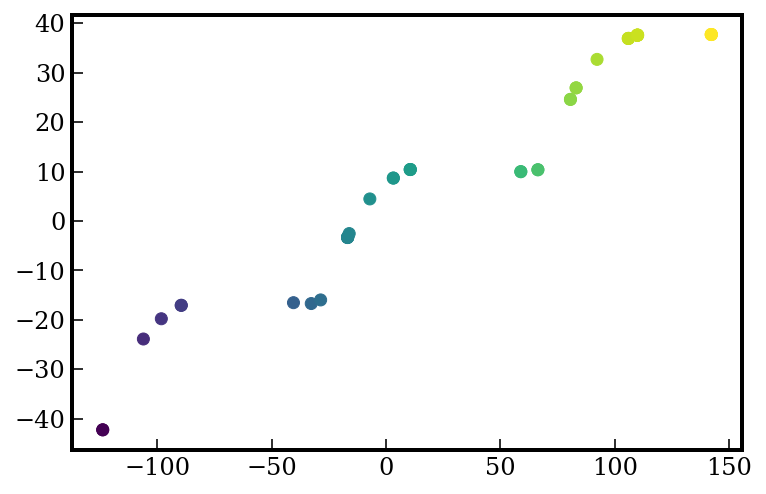

In [13]:
plt.scatter(rac_track-params.rac/astromet.mas, 
            dec_track-params.dec/astromet.mas, c=ts)

In [18]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [19]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(192.0437090529884,
 -34.85327606871708,
 10.168770689686639,
 96.38426115241136,
 26.691367650411447)

In [20]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
results

{'astrometric_matched_transits': 45,
 'visibility_periods_used': 18,
 'astrometric_n_obs_al': 405,
 'astrometric_params_solved': 31,
 'ra': 192.04370904313998,
 'ra_error': 0.010655498420246644,
 'dec': -34.85327606473862,
 'dec_error': 0.007811872375250843,
 'ra_dec_corr': -0.1273732895054941,
 'parallax': 10.171344869100137,
 'parallax_error': 0.013648063545411704,
 'ra_parallax_corr': 0.23243236685778382,
 'dec_parallax_corr': 0.11769356449101757,
 'pmra': 96.37822068223728,
 'pmra_error': 0.012363034418570704,
 'ra_pmra_corr': -0.4799943200278558,
 'dec_pmra_corr': 0.03605338131659608,
 'parallax_pmra_corr': -0.19531238646182347,
 'pmdec': 26.685263732287073,
 'pmdec_error': 0.008935082537711808,
 'ra_pmdec_corr': 0.03662277862551444,
 'dec_pmdec_corr': -0.39562476102988103,
 'parallax_pmdec_corr': -0.13860745607511804,
 'pmra_pmdec_corr': -0.21491119594208694,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 411.0823861241366,
 'astrometric_n_good_obs_al': 405,
 'UWE': 1.

### UWE and astrometric_excess_noise are small!

# Binary source

In [52]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))
params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+10

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [53]:
rac_track, dec_track=astromet.track(ts,params)

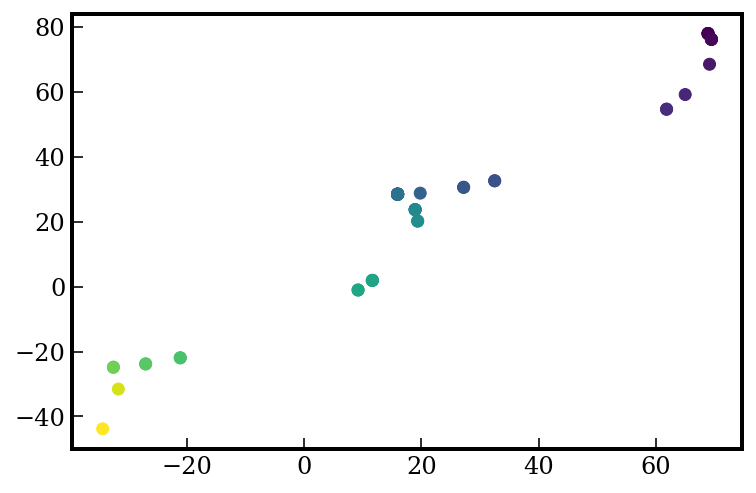

In [54]:
plt.scatter(rac_track-params.rac/astromet.mas, 
            dec_track-params.dec/astromet.mas, c=ts)

In [55]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = sigma_al_interp(params.phot_g_mean_mag)

In [56]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(14.877963661994183,
 -31.906567810472232,
 12.212027818487282,
 -50.42090237743703,
 -55.209510393496636)

In [57]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
results

{'astrometric_matched_transits': 57,
 'visibility_periods_used': 17,
 'astrometric_n_obs_al': 513,
 'astrometric_params_solved': 31,
 'ra': 14.877965322803394,
 'ra_error': 0.0250473148424078,
 'dec': -31.90656596031325,
 'dec_error': 0.01917028297421768,
 'ra_dec_corr': 0.023777118500000437,
 'parallax': 12.221801729250572,
 'parallax_error': 0.031244701636926855,
 'ra_parallax_corr': -0.09373147439243108,
 'dec_parallax_corr': 0.06420550705213769,
 'pmra': -50.64149560352588,
 'pmra_error': 0.034203831749165005,
 'ra_pmra_corr': 0.49288068623485476,
 'dec_pmra_corr': 0.177230733313465,
 'parallax_pmra_corr': 0.11325504927394088,
 'pmdec': -53.214185202230546,
 'pmdec_error': 0.03987445891747596,
 'ra_pmdec_corr': 0.006344386858027302,
 'dec_pmdec_corr': 0.666652385620282,
 'parallax_pmdec_corr': 0.26385712613265233,
 'pmra_pmdec_corr': 0.37463417456118586,
 'astrometric_excess_noise': 0.06649374472032543,
 'astrometric_chi2_al': 14579.088773840354,
 'astrometric_n_good_obs_al': 513,


### UWE is bigger!

# Iterate over many sources

In [61]:
nTest=100
dataNames=('rac','dec','pmrac','pmdec','parallax','phot_g_mean_mag',
           'M_tot','q','l','a','e','P','tPeri',
           'vTheta','vPhi','vOmega',
           'predict_dTheta','simple_dTheta',
           'N_obs','sigma_al','sigma_ac',
           'fit_rac','fit_dec','fit_pmrac','fit_pmdec','fit_parallax',
           'rac_error','dec_error','pmrac_error','pmdec_error','parallax_error',
           'N_vis','frac_good','AEN','UWE'
          )
allData=astropy.table.Table(names=dataNames)

# we'll generate nTest sets of parameters, and test each with a 0, 2 ,5 and 10 mSun BH
for i in tqdm.tqdm_notebook(range(nTest)):
    allData.add_row()
    thisRow=allData[i]
    
    # System astrometry & photometry parameters
    params=astromet.params()
    params.ra=360*np.random.rand()
    params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
    params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
    params.pmra=params.parallax*np.random.normal(scale=6.67)
    params.pmdec=params.parallax*np.random.normal(scale=6.67)
    params.phot_g_mean_mag=np.random.rand()*6+15    
    
    params.rac = params.ra*np.cos(np.deg2rad(params.dec))
    params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))
    
    # Scanning law information
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    # Binary parameters
    params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
    params.l=np.random.rand() # uniform light ratio
    params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
    params.a=10*np.random.rand()**2
    params.e=np.random.rand()
    params.vtheta=np.arccos(-1+2*np.random.rand())
    params.vphi=2*np.pi*np.random.rand()
    params.vomega=2*np.pi*np.random.rand()
    orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
    params.tperi=params.period*orbitalPhase
    
    # Calculate track
    rac_track, dec_track = astromet.track(ts,params)
    x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
    x_err = sigma_al_interp(params.phot_g_mean_mag)
    
    # Fit with Gaia emulator
    results=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
    # pmra in results includes the cos(dec) (standard gaia notation)
    
    # Add to dataset
    thisRow['rac']=1.*params.rac
    thisRow['dec']=1.*params.dec
    thisRow['pmrac']=params.pmrac
    thisRow['pmdec']=params.pmdec
    thisRow['parallax']=params.parallax
    thisRow['phot_g_mean_mag']=params.phot_g_mean_mag
    
    thisRow['M_tot']=4*(np.pi**2)*astromet.Galt/((params.period**2)*(params.a**3))
    thisRow['q']=params.q
    thisRow['l']=params.l
    thisRow['a']=params.a
    thisRow['e']=params.e
    thisRow['P']=params.period
    thisRow['tPeri']=1.*params.tperi
    thisRow['vTheta']=params.vtheta
    thisRow['vPhi']=params.vphi
    thisRow['vOmega']=params.vomega
    
    thisRow['simple_dTheta']=astromet.dtheta_simple(params)
    thisRow['predict_dTheta']=astromet.dtheta_full(params,np.min(ts),np.max(ts))  
    
    thisRow['fit_rac']=results['ra']*np.cos(np.deg2rad(results['dec']))
    thisRow['fit_dec']=results['dec']
    thisRow['fit_pmrac']=results['pmra']
    thisRow['fit_pmdec']=results['pmdec']
    thisRow['fit_parallax']=results['parallax']

    thisRow['rac_error']=results['ra_error']
    thisRow['dec_error']=results['dec_error']
    thisRow['pmrac_error']=results['pmra_error']
    thisRow['pmdec_error']=results['pmdec_error']
    thisRow['parallax_error']=results['parallax_error']

    thisRow['UWE']=results['UWE']

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function amax at 0x7f50087496a8>) found for signature:
 
 >>> amax(float64)
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload of function 'amax': File: numba/core/typing/npydecl.py: Line 348.
    With argument(s): '(float64)':[0m
[1m   No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function amax at 0x7f50087496a8>)[0m
[0m[1mDuring: typing of call at /home/andy/Documents/Research/Projects/GitRepos/astrometpy/astromet/track.py (266)
[0m
[1m
File "astromet/track.py", line 266:[0m
[1mdef findEtas(ts, period, eccentricity, tPeri=0, N_it = 10):
    <source elided>
        raise Exception("Eccentricity must be less than unity!")
[1m    if np.max(ell_array)>2.*np.pi:
[0m    [1m^[0m[0m


# findEtas is throwing bugs...